In [2]:
import numpy as np
import os, sys
import emcee
import yaml
import astropy.io.ascii as ascii
%pylab inline
from astropy.io import fits
from astropy.table import Table,join
import astropy as ap
from multiprocessing import Pool,Value
from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [3]:
from matplotlib.patches import Ellipse, Circle

In [4]:
source_id = np.loadtxt('source_id.txt',dtype=str)
z_table = []
z_2d = []
for id_name in source_id:
    z = Table.read('output_12pix/ELD_oh12_2d_id%s.txt'%id_name,format='ascii.commented_header')
    z_table.append(z)
    z_2d.append(z['me'].copy().reshape(24,24))

In [5]:
EL_data = []
for i in source_id:

    info = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.row.fits'%i,hdu=1)
    ra = info['ra']
    dec = info['dec']
#     z = info['redshift']
#     g141 = info['t_g141']
    hdu = fits.open('../grismspec_boss1244_210627/boss1244_DR210308_%s.full.fits'%i)
    sp_1d = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.1D.fits'%i,hdu=1)
    wave_1d = sp_1d['wave']
    flat = sp_1d['flat']
    Elines = {}
    w = 12
    seg = hdu[4].data[66-w:66+w,66-w:66+w].astype(float)
    seg[seg!=seg[w,w]] = nan
    seg/=seg[w,w]
    for j in range(len(hdu)):
        try:
            header = hdu[j].header
            EXTVER = header['EXTVER']
            EXTNAME = header['EXTNAME']
            if EXTVER in ['OII','Hg','Hb','OIII'] and EXTNAME =='LINE':
                flat_idx = np.argmin(np.abs(wave_1d - hdu[j].header['WAVELEN']))              
                Elines['flux_'+EXTVER] = (seg*hdu[j].data[66-w:66+w,66-w:66+w])/flat[flat_idx]
#             elif EXTVER in ['OII','Hg','Hb','OIII'] and EXTNAME =='LINEWHT':
#                 flat_idx = np.argmin(np.abs(wave_1d - hdu[j].header['WAVELEN']))
#                 Elines['err_'+EXTVER] = (seg*1/hdu[j].data[66-w:66+w,66-w:66+w])/flat[flat_idx]
        except:
            continue
    dat_ELflux = Table(Elines)
#     dat_ELflux.add_column(g141,index=0)
#     dat_ELflux.add_column(z,index=0)
    dat_ELflux.add_column(col=dec,index=0)
    dat_ELflux.add_column(col=ra,index=0)
    dat_ELflux.add_column(name='id',col=i,index=0)
    sci_img = hdu[5].data[66-w:66+w,66-w:66+w]*seg
    hdu.close()
    dat_ELflux['flux_OIII'] *= 3./4.
#     dat_ELflux['err_OIII'] *= 3./4.
    
    #------------ change the unit of line flux/err to 1e-19
    linelist = [x.split('_')[-1] for x in dat_ELflux.colnames if 'flux_' in x]
    for line in linelist:
        dat_ELflux['flux_'+line] /= 1.e-19
#         dat_ELflux['err_'+line] /= 1.e-19
    EL_data.append(dat_ELflux)

In [6]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

In [7]:
ra = np.array([])
dec = np.array([])
for i in source_id:
    info = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.row.fits'%i,hdu=1)
    ra = np.append(ra,asarray(info['ra']))
    dec = np.append(dec,asarray(info['dec']))

In [8]:
j1244_cut = fits.open('../Photometry/j1244_cut.fits')
j1244_cut_img = j1244_cut[0].data
j1244_cut.close()

h1244_cut = fits.open('../Photometry/h1244_cut.fits')
h1244_cut_img = h1244_cut[0].data
h1244_cut.close()

w_j_cut = WCS(j1244_cut[0].header)
j1244_cut.close()

c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)

j_x = w_j_cut.world_to_pixel(c)[0]
j_y = w_j_cut.world_to_pixel(c)[1]

In [9]:
h1244_wht = fits.open('../Photometry/h1244_wht_cut.fits')
h1244_wht_img = h1244_wht[0].data

In [10]:
s_pix = 12
j_stamp = []
h_stamp = []
h_wht_stamp = []
for i in range(len(source_id)):

    j_cutx = round(j_x[i])
    j_cuty = round(j_y[i])
 
    j_stamp.append(j1244_cut_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    h_stamp.append(h1244_cut_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    h_wht_stamp.append(h1244_wht_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])

In [63]:
# for i in range(len(source_id)):
#     hdu = fits.PrimaryHDU(data=h_stamp[i])
#     hdu.writeto('galfit/h1244_s%s.fits'%source_id[i],overwrite=True)
    
#     hdu = fits.PrimaryHDU(data=h_wht_stamp[i])
#     hdu.writeto('galfit/h1244_wht_s%s.fits'%source_id[i],overwrite=True)

In [11]:
fitnumber = ['0'*(2-len(str(i)))+str(i) for i in np.arange(len(z_2d))+1]

galfit = []
for i,n in enumerate(source_id):
    file = open("galfit/galfit_output/galfit_%s.txt"%n, "r")
    name = file.readlines()
    x = float(name[40][4:11])
    y = float(name[40][13:20])
    R_e = float(name[42][4:11])
    ab = float(name[47][4:11])
    angle = float(name[48][4:11])
    
    a = R_e/ab**0.5
    b = R_e*ab**0.5
    
    galfit.append(np.array([x,y,a,b,angle]))

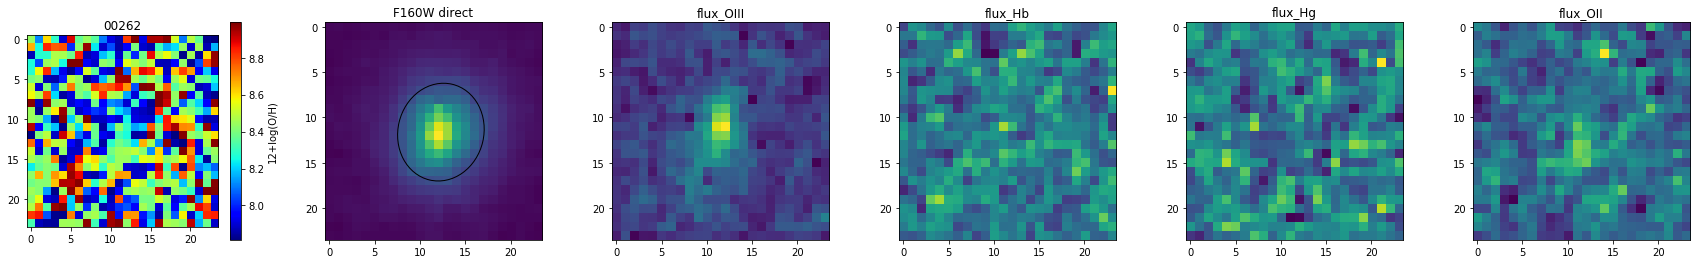

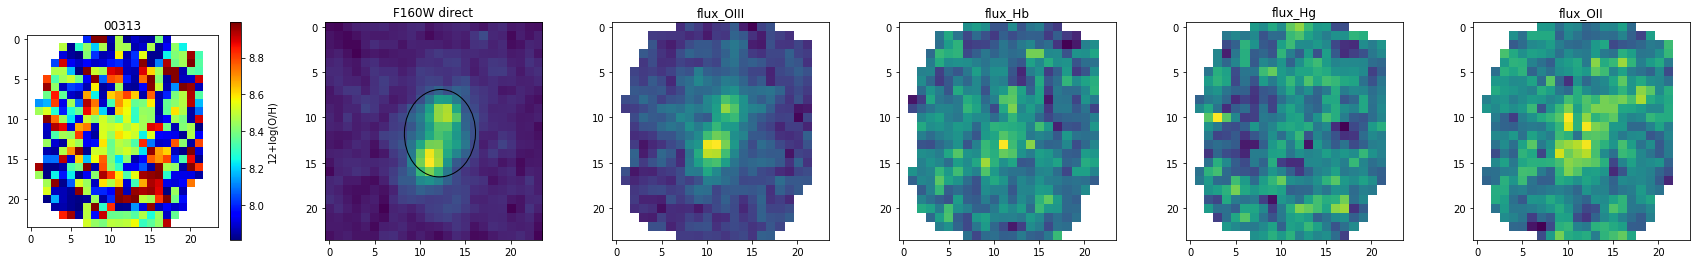

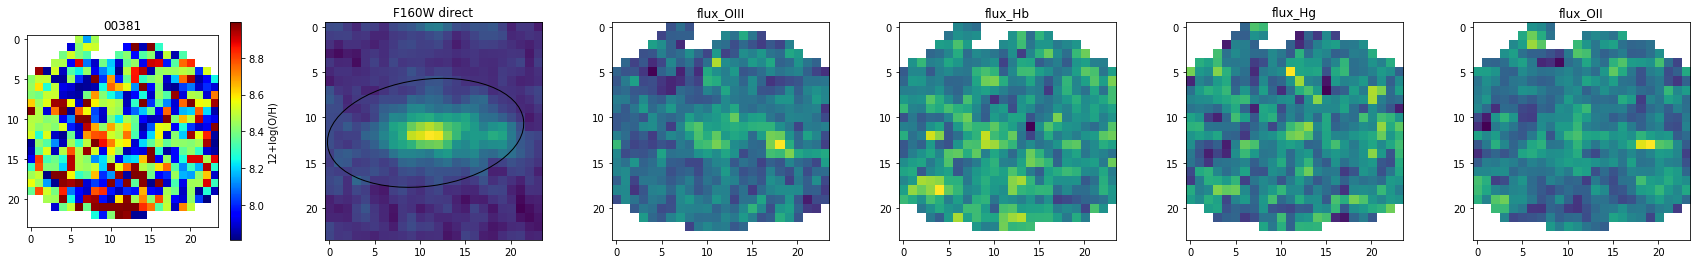

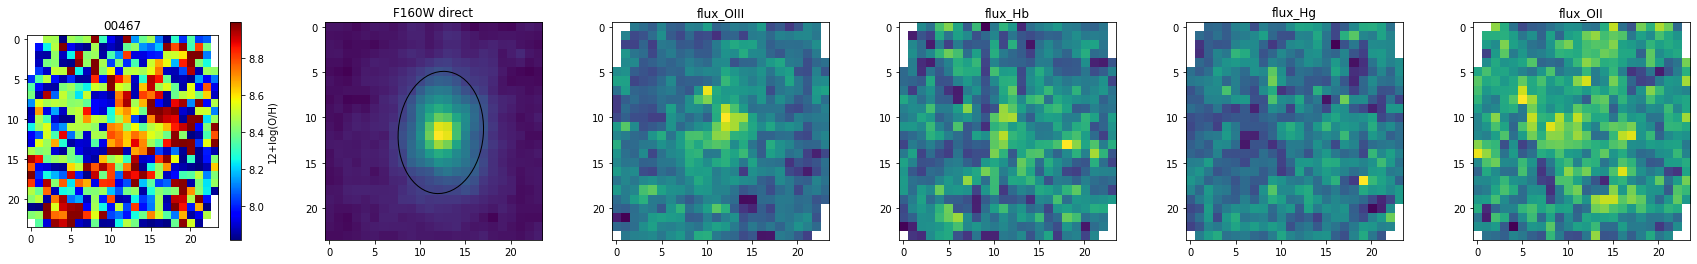

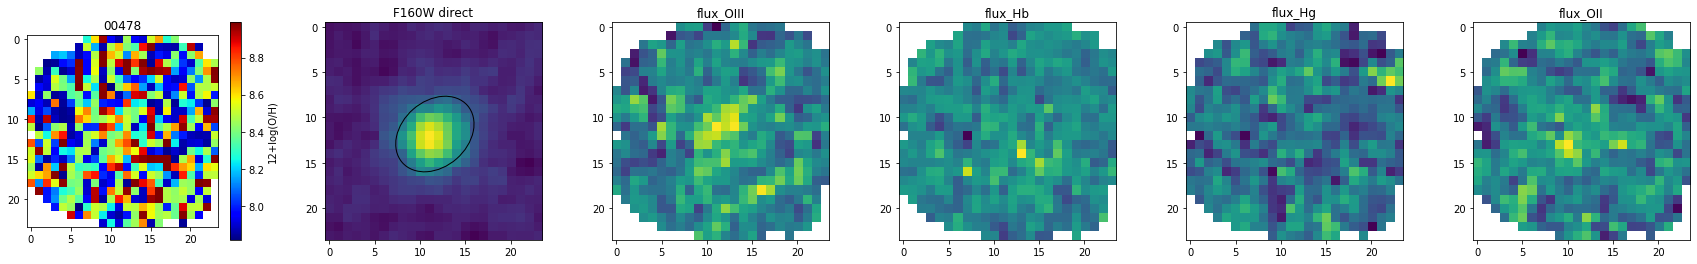

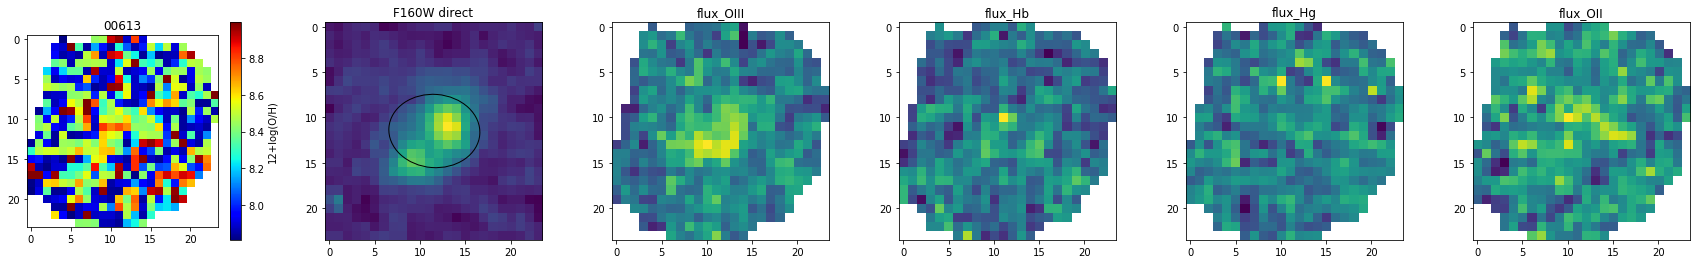

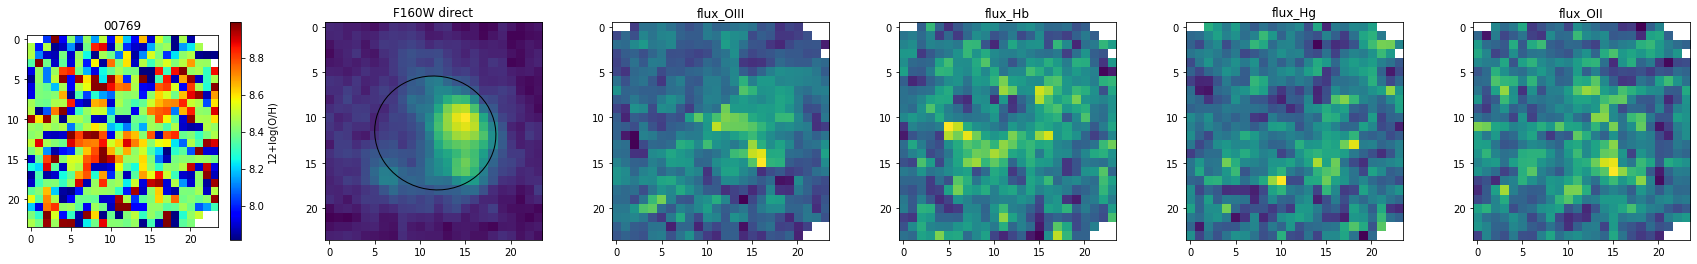

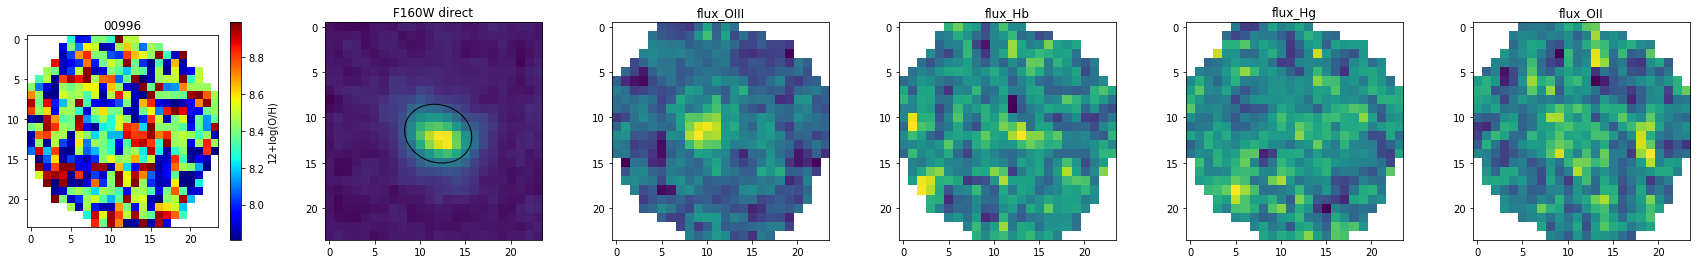

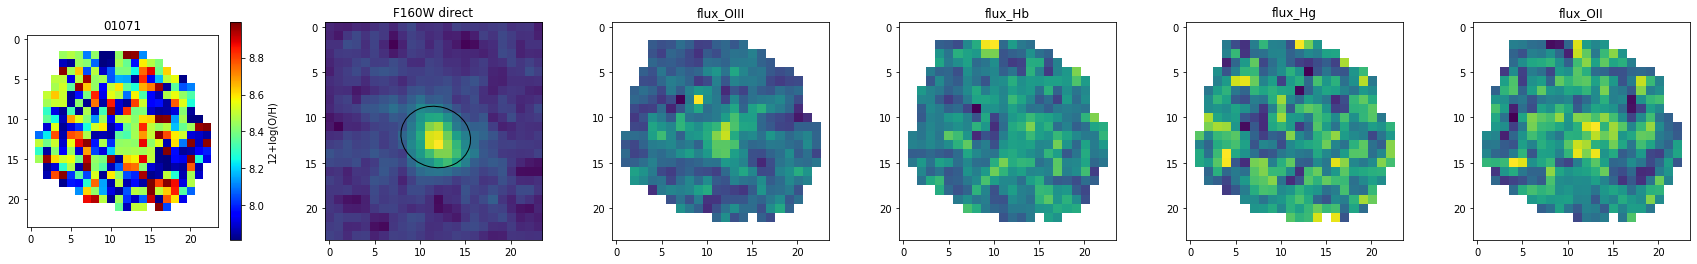

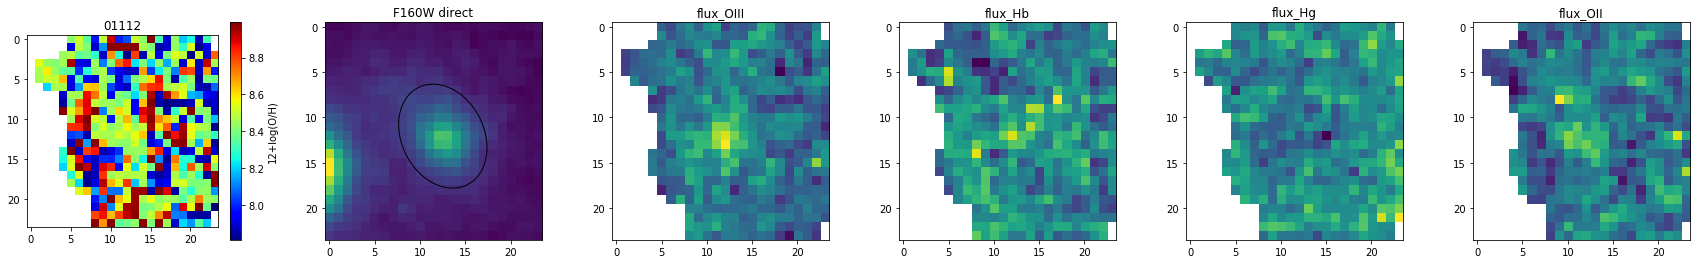

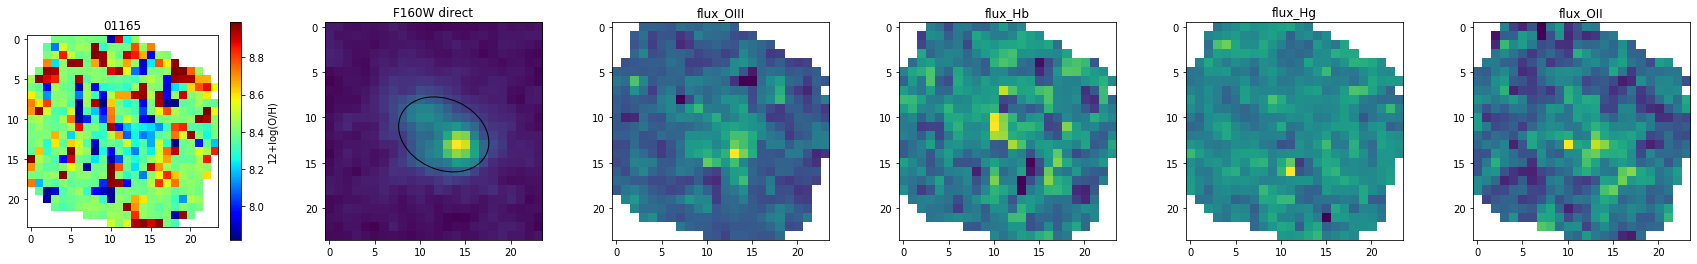

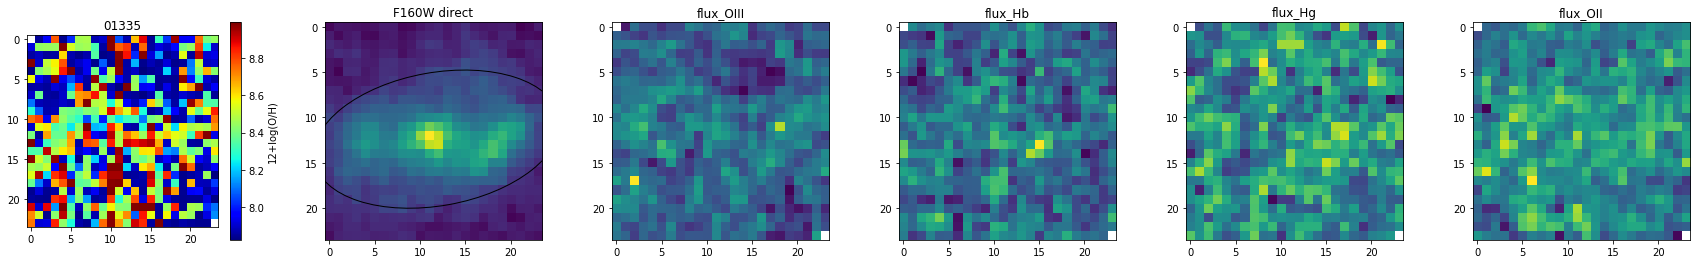

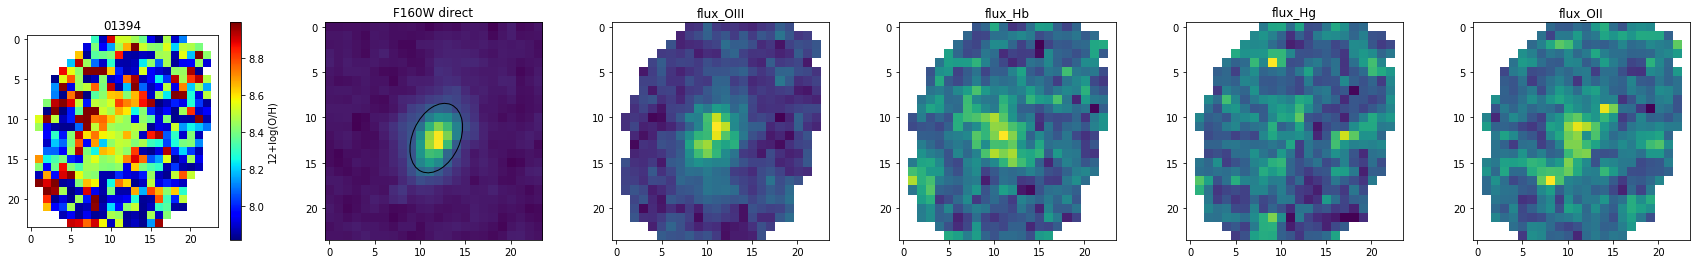

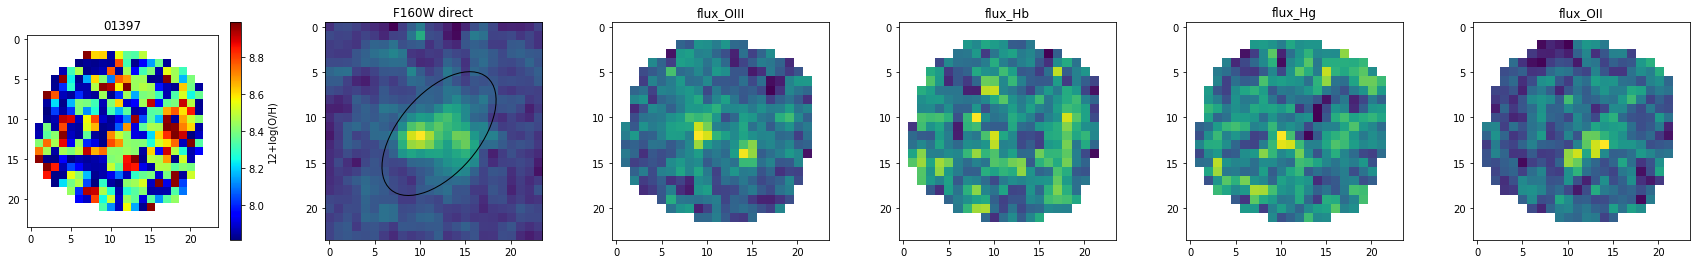

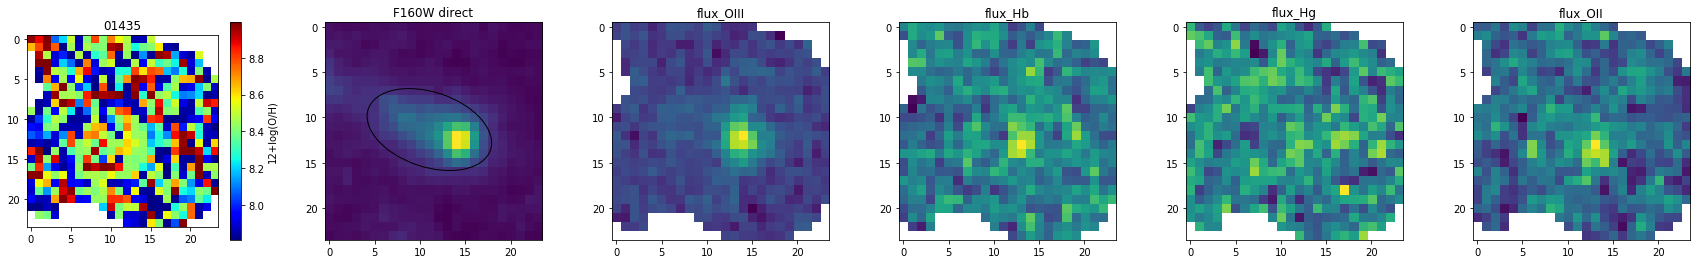

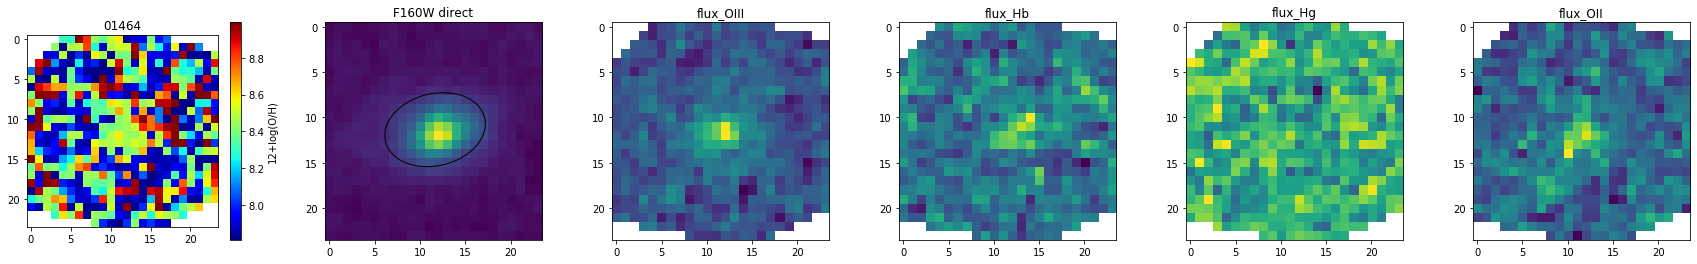

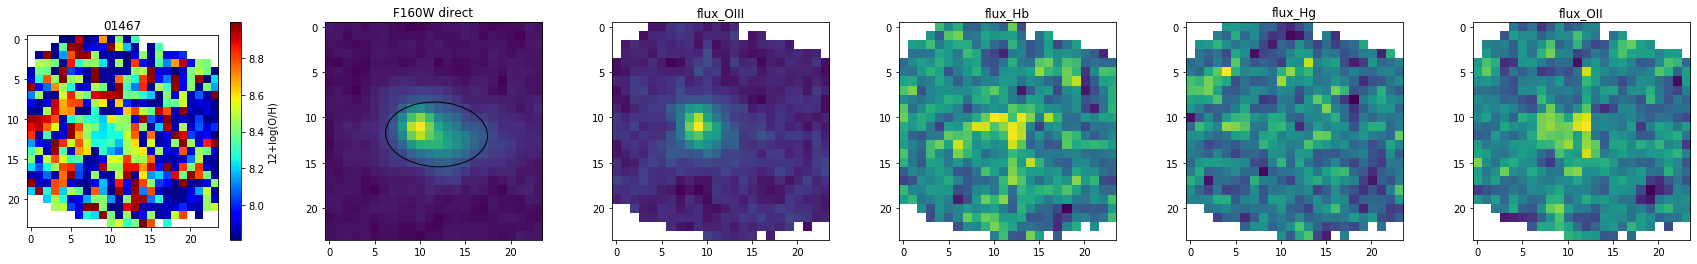

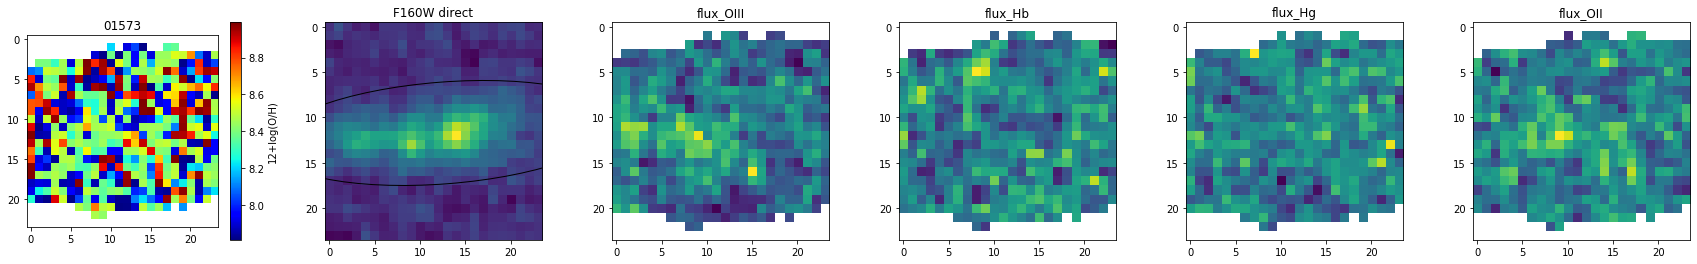

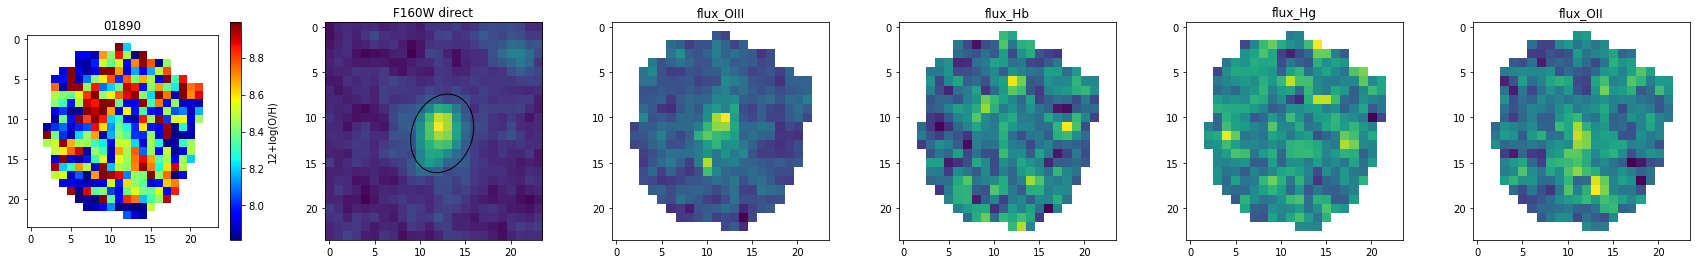

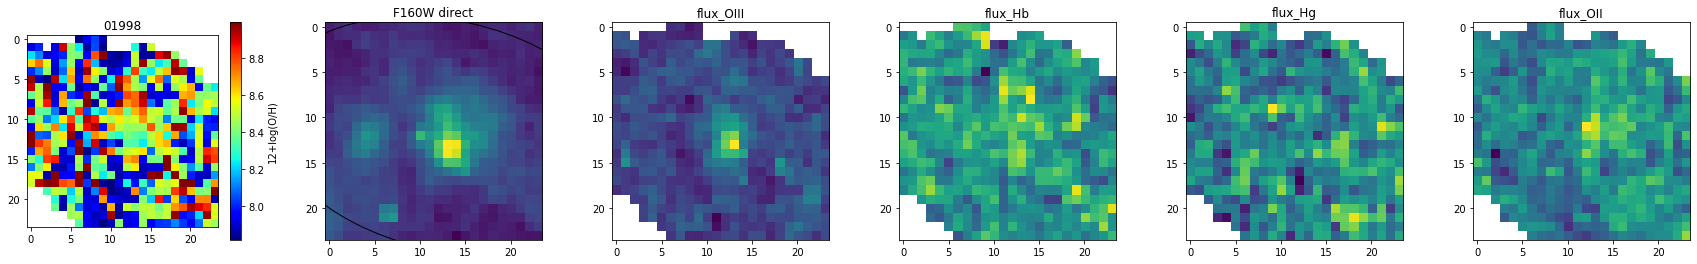

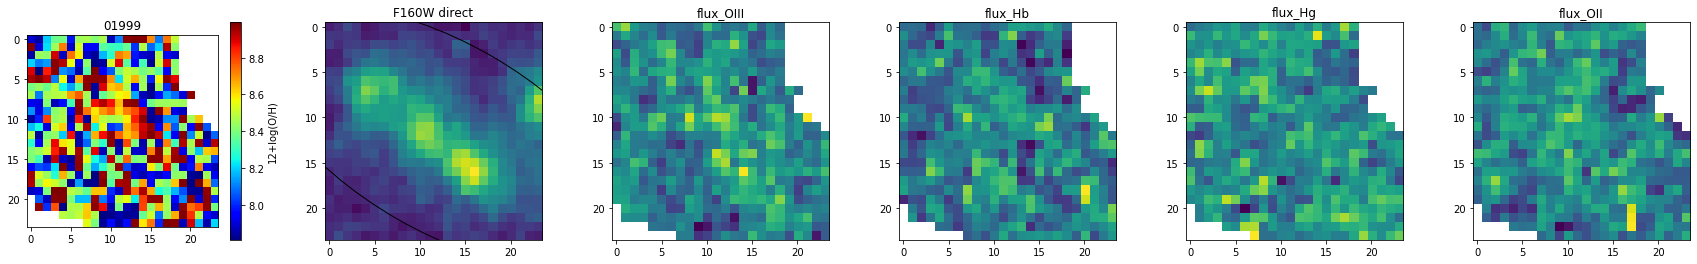

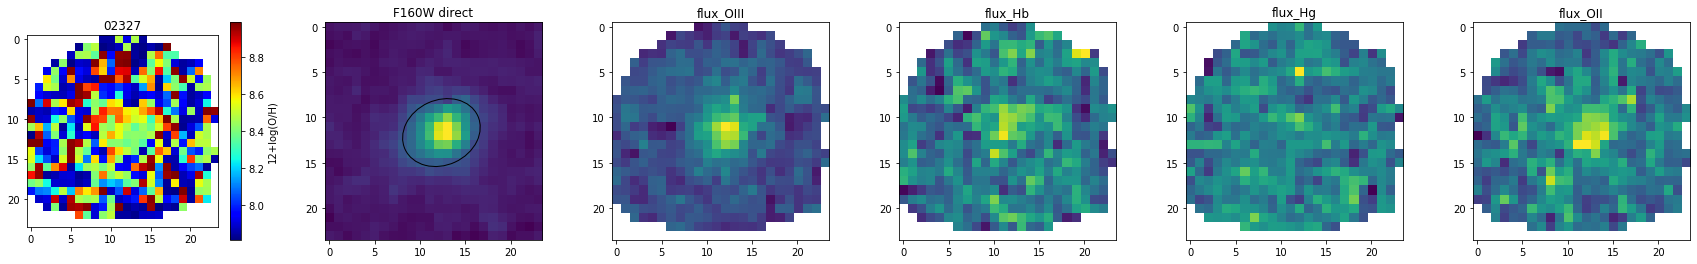

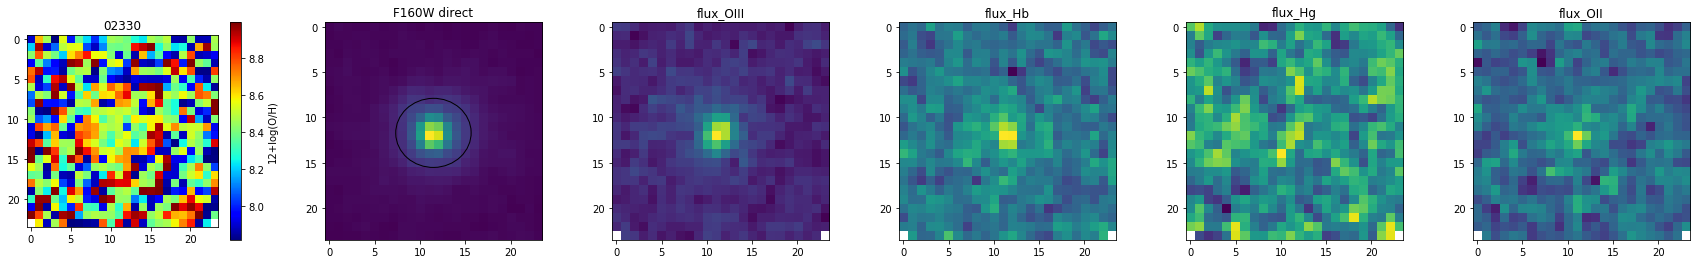

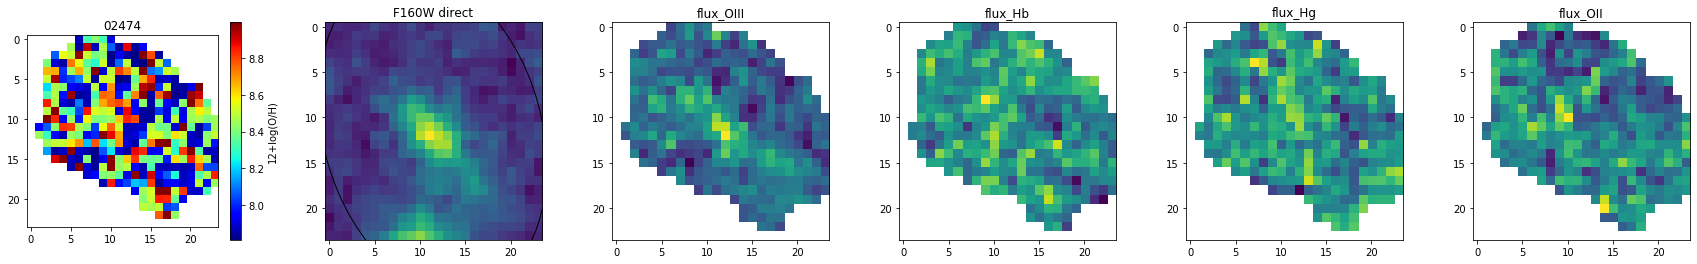

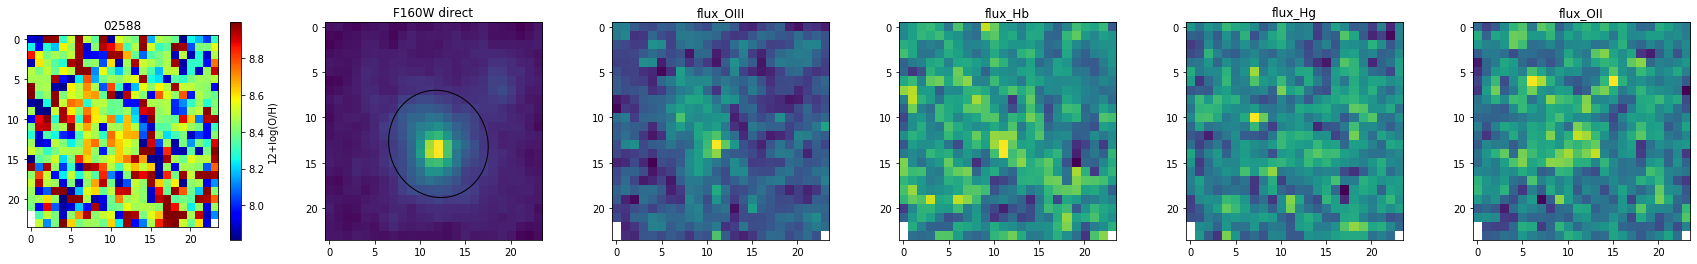

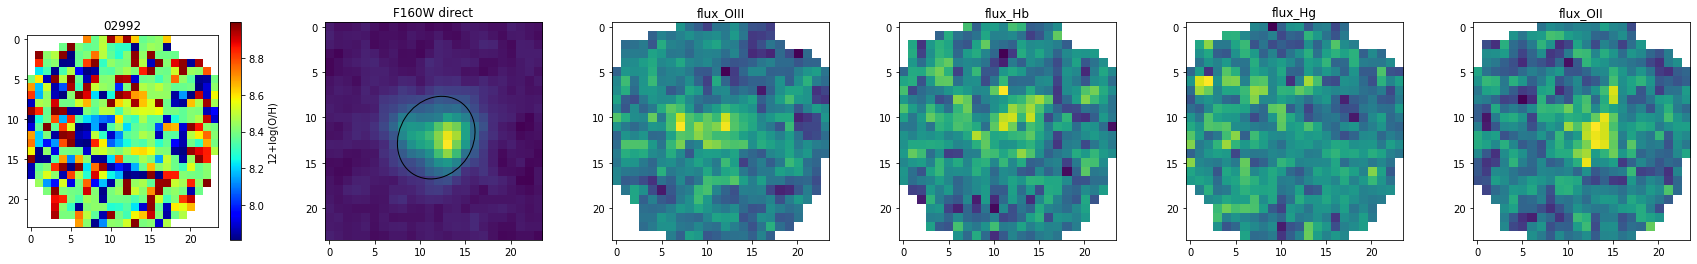

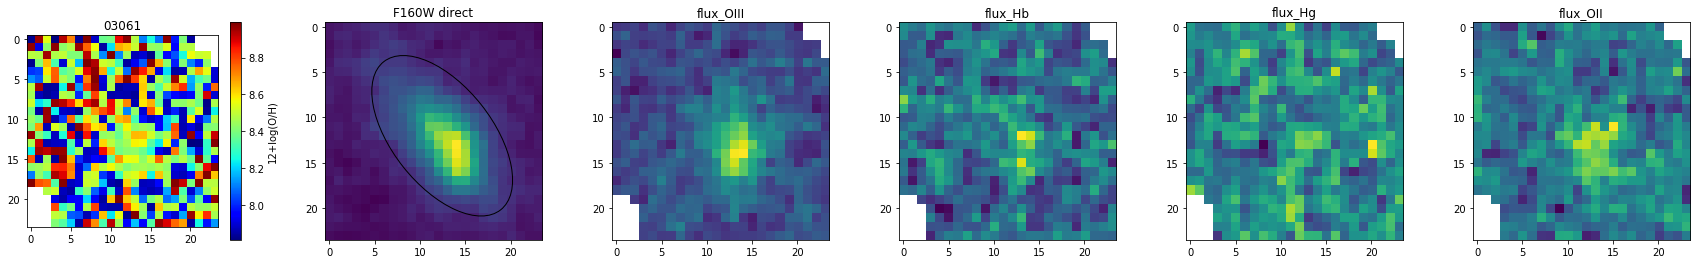

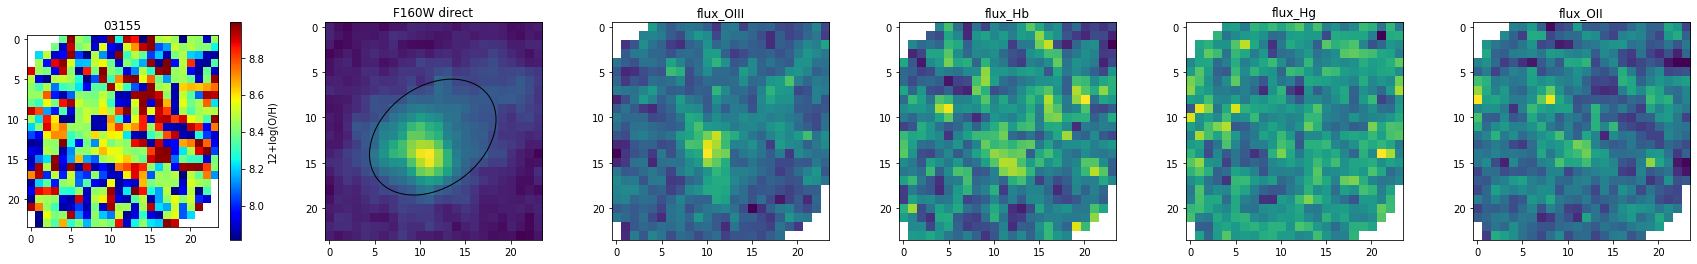

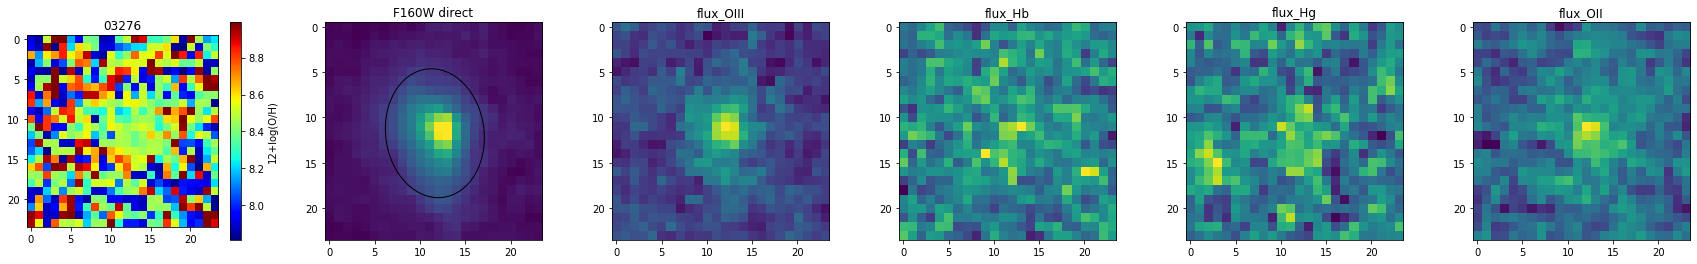

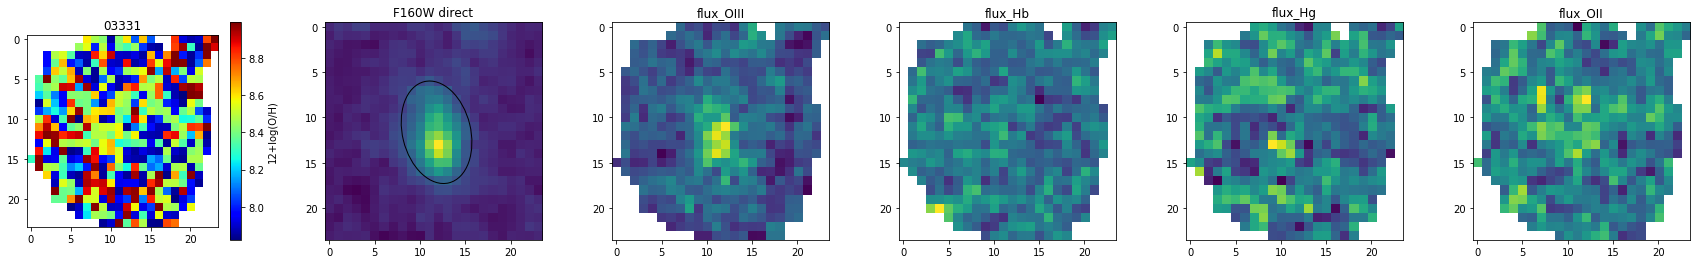

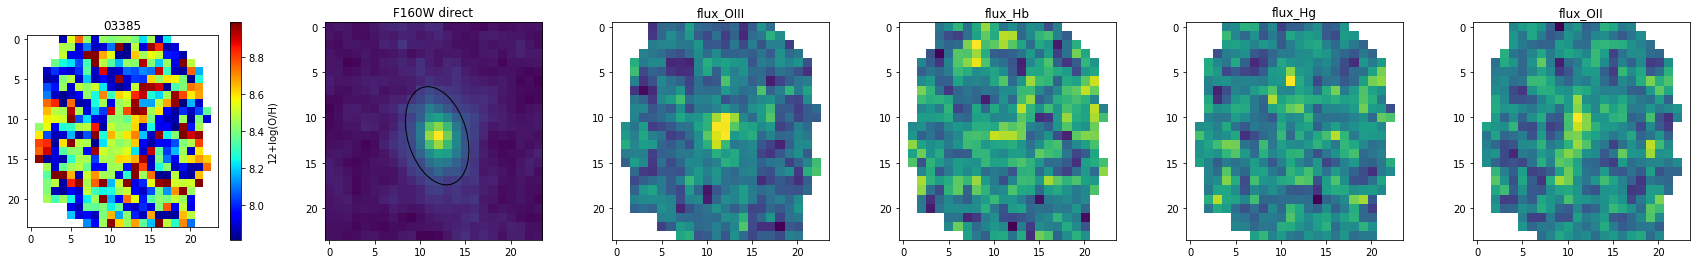

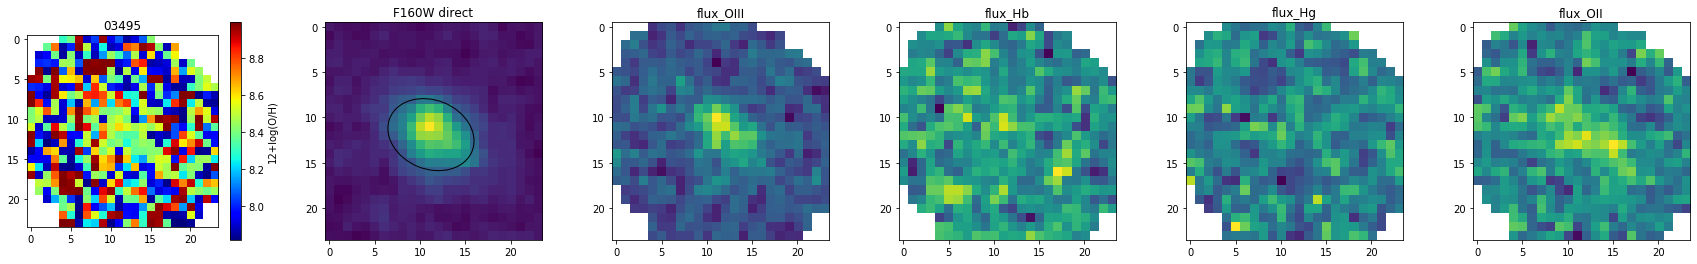

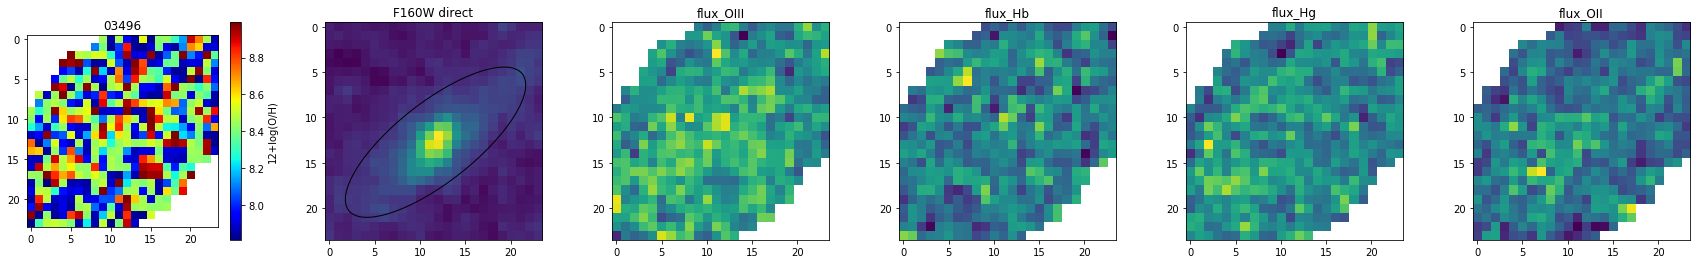

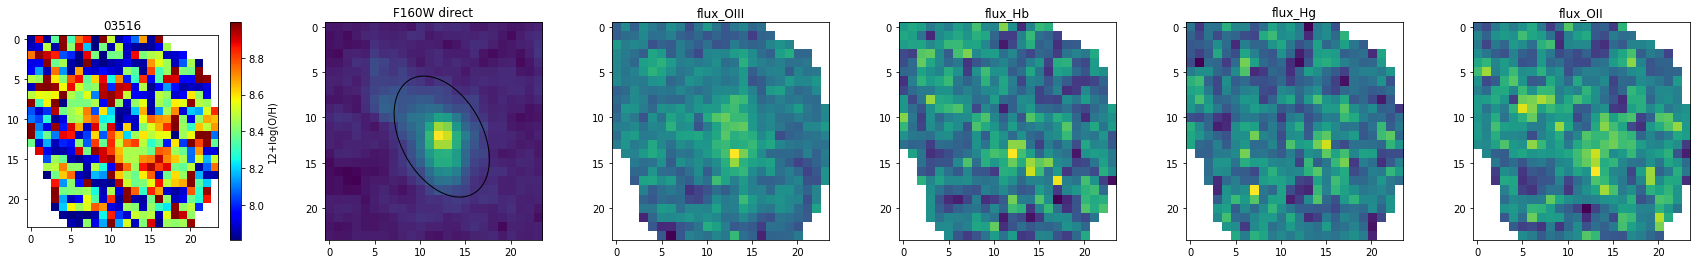

In [12]:
EL = ['flux_OIII','flux_Hb','flux_Hg','flux_OII']


for i in range(len(z_2d)):
# for i in [23]:

    fig,ax = subplots(1,6,figsize=(30,4))

    im1 = ax[0].imshow(z_2d[i],cmap='jet')
    ax[0].set_title(source_id[i])
    plt.colorbar(im1,ax=ax[0],label='12+log(O/H)')
    
    ax[1].imshow(h_stamp[i])
    ax[1].set_title('F160W direct')
    for j,a in enumerate(ax[2:]):
        a.imshow(asarray(EL_data[i][EL[j]]) )
        a.set_title(EL[j])
    
    ell1 = Ellipse(xy = (galfit[i][:2]-1), width = 2*galfit[i][2], height = 2*galfit[i][3], angle = 90+galfit[i][4], ec= 'k',fill=False, alpha=1.0)
    ax[1].add_artist(ell1)
    plt.show()
